## Atlas subsampling 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [8]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

In [40]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/atlas_subsampling/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [67]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [69]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6], 'closest_ACR':pal[2], 'random_ACR':pal[8]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [70]:
%%R -i figdir -i design_palette_df
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [52]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

### Experiment set up

```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/

## Atlas subsampling comparison
for ct in natural_killer_cell classical_monocyte central_memory_CD4_positive_alpha_beta_T_cell effector_memory_CD8_positive_alpha_beta_T_cell; do
    d=${outdir}/qPBMC_500cells_demo_perturb_cell_type${ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
    for method in random closest; do
            echo "python run_ctrl_subsampling.py $d $method --random_seed 41" |\
            bsub -G teichlab -o logfile-subsampling-%J.out -e logfile-subsampling-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done
```

## Parse results

In [22]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc

def harmonize_output(adata, signif_alpha=0.1):
    if adata.isbacked:
        sample_adata = adata.uns['nhood_adata'].to_memory().T
    else:
        sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()


def parse_design(adata, ct, ref_design):
    harmonize_output(adata)
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = ct
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = ct
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = ct
    return(nhoods_df, tpr_df, auprc_df)

In [23]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'
cts = ['natural_killer_cell',
       'classical_monocyte',
       'central_memory_CD4_positive_alpha_beta_T_cell',
       'effector_memory_CD8_positive_alpha_beta_T_cell']

In [37]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
for ct in cts:
    print(ct)
    d = f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    print(os.listdir(outdir + d + 'ctrl_by_subsampling_random41'))
    ## Read results with/wo matched controls
    nhoods_res_df = pd.read_csv(outdir + d + '/nhoods_obs.csv', index_col = 0)
    tpr_res_df = pd.read_csv(outdir + d + '/TPR_res.csv', index_col = 0)
    nhoods_res_df = nhoods_res_df[nhoods_res_df['design'].isin(['ACR', 'AR'])]
    tpr_res_df = tpr_res_df[tpr_res_df['design'].isin(['ACR', 'AR'])]
    ## Read results with close subsample
    closest_adata = milopy.utils.read_milo_adata(outdir + d + 'ctrl_by_subsampling_closest41/acr_design.h5ad', backed=True)
    nhoods_df_closest, tpr_df_closest, _ = parse_design(closest_adata, ct, 'closest_ACR')
    ## Read results with random subsample
    random_adata = milopy.utils.read_milo_adata(outdir + d + 'ctrl_by_subsampling_random41/acr_design.h5ad', backed=True)
    nhoods_df_random, tpr_df_random, _ = parse_design(random_adata, ct, 'random_ACR')
    ## store results
    nhoods_res_df = pd.concat([nhoods_res_df, nhoods_df_random, nhoods_df_closest])
    tpr_res_df = pd.concat([tpr_res_df, tpr_df_random, tpr_df_closest])
    nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
    tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])

natural_killer_cell
['acr_design.nhood_adata.h5ad', 'acr_design.h5ad', 'model_fit_query2atlas', 'model_atlas']
classical_monocyte
['acr_design.nhood_adata.h5ad', 'acr_design.h5ad', 'model_fit_query2atlas', 'model_atlas']
central_memory_CD4_positive_alpha_beta_T_cell
['acr_design.nhood_adata.h5ad', 'acr_design.h5ad', 'model_fit_query2atlas', 'model_atlas']
effector_memory_CD8_positive_alpha_beta_T_cell
['acr_design.nhood_adata.h5ad', 'acr_design.h5ad', 'model_fit_query2atlas', 'model_atlas']


## Plot OOR fraction vs logFC

In [53]:
nhoods_res_df_all.OOR_state_name = [short_pop_names[x] for x in nhoods_res_df_all.OOR_state_name]

In [77]:
%%R -i nhoods_res_df_all
head(nhoods_res_df_all)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                                            index_cell kth_distance
1 10_1038_s41591_021_01329_2-BGCV02_GTATCTTTCTGCTGTC-1     1.609069
2 10_1038_s41591_021_01329_2-BGCV02_TGACGGCGTCATATCG-1     1.629461
3 10_1038_s41591_021_01329_2-BGCV02_CAGAGAGAGCAGGCTA-1     1.608049
4 10_1038_s41591_021_01329_2-BGCV02_CGCGGTATCTTGCCGT-1     1.692860
5 10_1038_s41591_021_01329_2-BGCV02_GCGCAGTAGGCACATG-1     1.660691
6 10_1038_s41591_021_01329_2-BGCV02_GTACGTAAGGATTCGG-1     1.513696
                                     nhood_annotation nhood_annotation_frac
1       central_memory_CD4_positive_alpha_beta_T_cell             0.6538461
2       central_memory_CD4_positive_alpha_beta_T_cell             0.8059701
3       central_memory_CD4_positive_alpha_beta_T_cell             0.6228070
4 naive_thymus_derived_CD8_positive_alpha_beta_T_cell             0.8823530
5      effector_memory_CD8_positive_alpha_beta_T_cell             0.8823530
6       central_memory_CD4_positive_alpha_beta_T_cell             0.

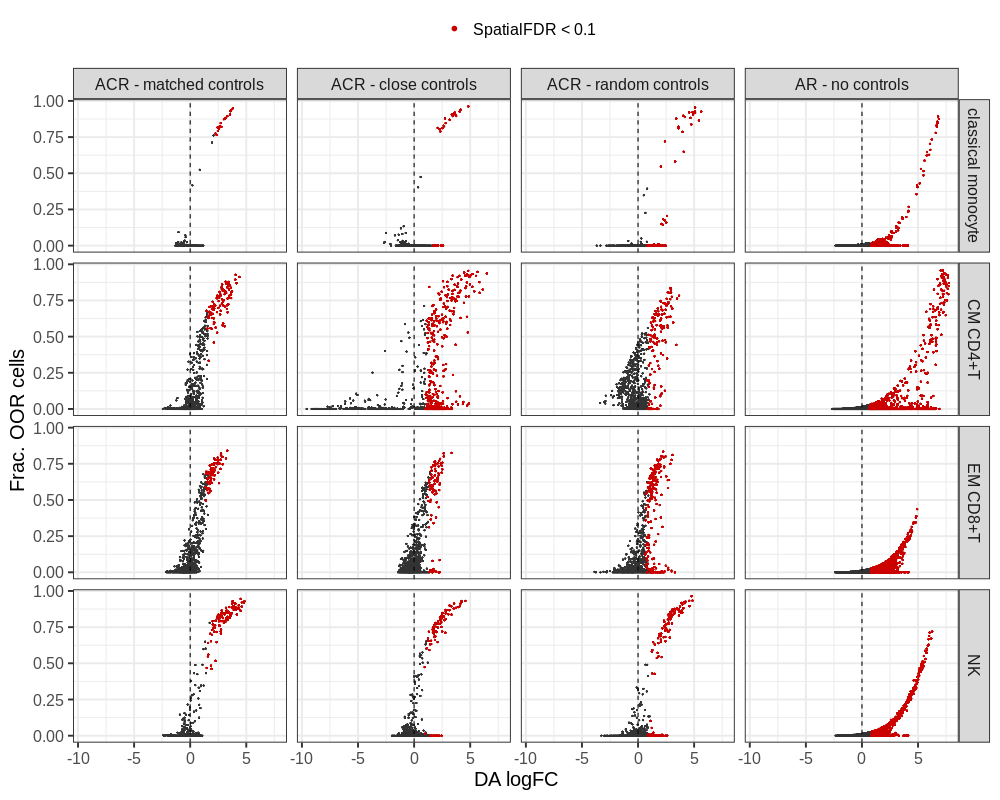

In [78]:
%%R -w 1000 -h 800 -i figdir
library(ggrastr)

design_labeller <- c(
    ACR = 'ACR - matched controls',
    closest_ACR = 'ACR - close controls',
    random_ACR = 'ACR - random controls',
    AR = 'AR - no controls'
)

nhoods_res_df_all %>%
    mutate(design=factor(design, levels=names(design_labeller))) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    rasterise(geom_point(size=0.3, color='grey20'), dpi=300) +
    rasterise(geom_point(data=. %>% filter(OOR_signif == 1), aes(color='SpatialFDR < 0.1'),
               size=0.4), dpi=300) +
    facet_grid(OOR_state_name~design, labeller=labeller(design=design_labeller)) +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=20) +
    scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
    geom_vline(xintercept=0, linetype=2) +
    xlab('DA logFC') + ylab('Frac. OOR cells') +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'fracVSlogFC_cts.png'), width=12, height=8) +
    ggsave(paste0(figdir, 'fracVSlogFC_cts.pdf'), width=12, height=8)

## TPR/FDR/FPR

In [57]:
tpr_res_df_all.OOR_state_name = [short_pop_names[x] for x in tpr_res_df_all.OOR_state_name]

In [58]:
%%R -i tpr_res_df_all
head(tpr_res_df_all)

   TP   FP FN    TN       TPR        FPR       FDR      design
1  87    0 25   807 0.7767857 0.00000000 0.0000000         ACR
2 135 3299  0 40273 1.0000000 0.07571376 0.9606872          AR
3  83   74 13   815 0.8645833 0.08323960 0.4713376  random_ACR
4  73   13 37   833 0.6636364 0.01536643 0.1511628 closest_ACR
5  18    0  5   864 0.7826087 0.00000000 0.0000000         ACR
6  30 3872  0 42684 1.0000000 0.08316866 0.9923116          AR
      OOR_state_name
1                 NK
2                 NK
3                 NK
4                 NK
5 classical monocyte
6 classical monocyte


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


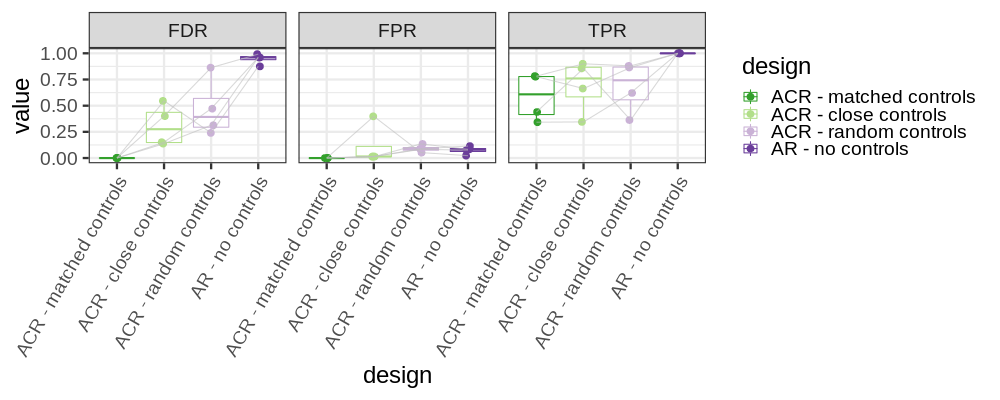

In [79]:
%%R -i tpr_res_df_all -w 1000 -h 400 

pl1 <- tpr_res_df_all %>%
    mutate(design=factor(design, levels=names(design_labeller))) %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette, labels=design_labeller) +
    scale_x_discrete(labels=design_labeller) +
    theme_bw(base_size=24) +
    theme(axis.text.x = element_text(angle=60, hjust=1, vjust=1))

pl1 + 
    ggsave(paste0(figdir, 'TPR_FPR_FDR.png'), width=12, height=6) +
    ggsave(paste0(figdir, 'TPR_FPR_FDR.pdf'), width=12, height=6)

---